In [1]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
train_df_raw = pd.read_excel('relaytrain_2_2_2_2_2.xlsx')
test_df_raw = pd.read_excel('relaytest_2_2_2_2_2.xlsx')
train_df_raw.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,1,Monday,CHO
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,1,Friday,CHO
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,1,Wednesday,CHO
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,1,Thursday,RIC
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,1,Monday,RIC


In [3]:
# Store labels separately from training data
train_labels = train_df_raw['retained']
test_labels = test_df_raw['retained']

In [4]:
# Remove labels from training data
train_df = train_df_raw.drop('retained', axis=1, inplace=False)
test_df = test_df_raw.drop('retained', axis=1, inplace=False)

# Step 1: Data Exploration

Questions:

* What is the cardinality of city?
* What is the cardinality of custid? Does custid matter (e.g. repeat customers?)
* What is the ratio of customers retained to customers lost?
* Which columns correlate the most with our target?
* Is there any multicollinearity in our dataset?
* Do the dates matter? How can we transform these so that we can use them in our model?

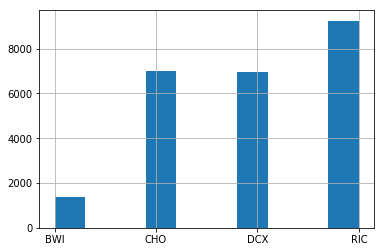

In [5]:
train_df.city.hist()

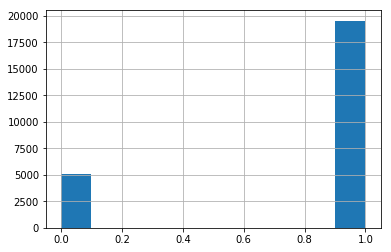

In [6]:
train_labels.hist()

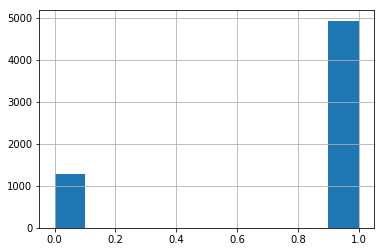

In [7]:
test_labels.hist()

### Class Imbalance!

Our labels have a large class imbalance. Customers lost represent only 25% of our data in both our training and testing sets. We need to balance this using stratified K-Fold Cross Validation, or through Naive Oversampling. 

In [26]:
one_hot_train_df = pd.get_dummies(train_df.drop(['custid', 'train', 'created', 'firstorder', 'lastorder'], axis=1))
one_hot_test_df = pd.get_dummies(test_df.drop(['custid', 'train', 'created', 'firstorder', 'lastorder'], axis=1))
one_hot_train_df.head()

,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday_Friday,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BWI,city_CHO,city_DCX,city_RIC
0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1,0,0,0,0,0,0,0,1,0,0
2,0,0.000000,0.000000,33.58,0.059908,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,30,90.000000,13.333333,111.91,0.008850,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [34]:
one_hot_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24579 entries, 0 to 24578
Data columns (total 19 columns):
esent               24579 non-null int64
eopenrate           24579 non-null float64
eclickrate          24579 non-null float64
avgorder            24579 non-null float64
ordfreq             24579 non-null float64
paperless           24579 non-null int64
refill              24579 non-null int64
doorstep            24579 non-null int64
favday_Friday       24579 non-null uint8
favday_Monday       24579 non-null uint8
favday_Saturday     24579 non-null uint8
favday_Sunday       24579 non-null uint8
favday_Thursday     24579 non-null uint8
favday_Tuesday      24579 non-null uint8
favday_Wednesday    24579 non-null uint8
city_BWI            24579 non-null uint8
city_CHO            24579 non-null uint8
city_DCX            24579 non-null uint8
city_RIC            24579 non-null uint8
dtypes: float64(4), int64(4), uint8(11)
memory usage: 1.8 MB


In [28]:
 rf = RandomForestClassifier()
rf.fit(one_hot_train_df, train_labels)
rf_train_pred = rf.predict(one_hot_train_df)
rf_test_pred = rf.predict(one_hot_test_df)

In [30]:
print("Classification Report: Random Forest (Training)")
print(classification_report(train_labels, rf_train_pred))

print("Classification Report: Random Forest (Testing)")
print(classification_report(test_labels, rf_test_pred))

Classification Report: Random Forest (Training)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5042
          1       1.00      1.00      1.00     19537

avg / total       1.00      1.00      1.00     24579

Classification Report: Random Forest (Testing)
             precision    recall  f1-score   support

          0       0.91      0.85      0.88      1287
          1       0.96      0.98      0.97      4935

avg / total       0.95      0.95      0.95      6222



In [32]:
lr = LogisticRegression()
lr.fit(one_hot_train_df, train_labels)
lr_train_preds = lr.predict(one_hot_train_df)
lr_test_preds = lr.predict(one_hot_test_df)

In [33]:
print("Classification Report: Logistic Regression (Training)")
print(classification_report(train_labels, lr_train_preds))

print("Classification Report: Logistic Regression (Testing)")
print(classification_report(test_labels, lr_test_preds))

Classification Report: Logistic Regression (Training)
             precision    recall  f1-score   support

          0       0.88      0.83      0.85      5042
          1       0.96      0.97      0.96     19537

avg / total       0.94      0.94      0.94     24579

Classification Report: Logistic Regression (Testing)
             precision    recall  f1-score   support

          0       0.88      0.83      0.86      1287
          1       0.96      0.97      0.96      4935

avg / total       0.94      0.94      0.94      6222



In [35]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(19,)))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
history = model.fit(one_hot_train_df, train_labels, epochs=20, verbose=1, validation_data=(one_hot_test_df, test_labels))

Train on 24579 samples, validate on 6222 samples
Epoch 1/20
24579/24579 [==============================] - 2s 93us/step - loss: 0.1412 - acc: 0.9493 - val_loss: 0.1421 - val_acc: 0.9495
Epoch 2/20
24579/24579 [==============================] - 2s 96us/step - loss: 0.1408 - acc: 0.9502 - val_loss: 0.1463 - val_acc: 0.9495
Epoch 3/20
24579/24579 [==============================] - 2s 92us/step - loss: 0.1422 - acc: 0.9480 - val_loss: 0.1453 - val_acc: 0.9471
Epoch 4/20
24579/24579 [==============================] - 2s 92us/step - loss: 0.1408 - acc: 0.9495 - val_loss: 0.1496 - val_acc: 0.9470
Epoch 5/20
24579/24579 [==============================] - 2s 92us/step - loss: 0.1406 - acc: 0.9494 - val_loss: 0.1448 - val_acc: 0.9505
Epoch 6/20
24579/24579 [==============================] - 2s 93us/step - loss: 0.1401 - acc: 0.9494 - val_loss: 0.1487 - val_acc: 0.9484
Epoch 7/20
24579/24579 [==============================] - 2s 95us/step - loss: 0.1407 - acc: 0.9496 - val_loss: 0.1436 - val_acc:

In [46]:
history = history.history

In [47]:
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [48]:
epochs = [i for i in range (1, 21)]

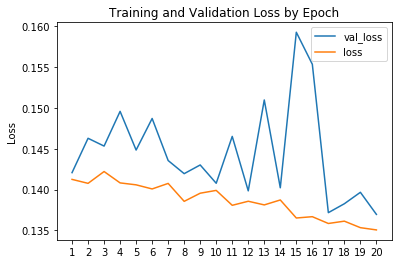

In [53]:
plt.figure()
plt.title('Training and Validation Loss by Epoch')
plt.plot(epochs, history['val_loss'])
plt.plot(epochs, history['loss'])
plt.legend(['val_loss', 'loss'])
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

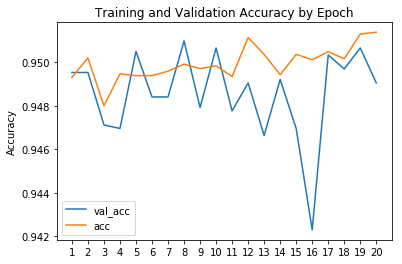

In [54]:
plt.figure()
plt.title('Training and Validation Accuracy by Epoch')
plt.plot(epochs, history['val_acc'])
plt.plot(epochs, history['acc'])
plt.legend(['val_acc', 'acc'])
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.show()

In [55]:
from sklearn.svm import SVC

In [56]:
svc = SVC()
svc.fit(one_hot_train_df, train_labels)
svc_train_preds = svc.predict(one_hot_train_df)
svc_test_preds = svc.predict(one_hot_test_df)

In [57]:
print("Classification Report: Support Vector Machine (Training)")
print(classification_report(train_labels, svc_train_preds))

print("Classification Report: Support Vector Machine (Testing)")
print(classification_report(test_labels, svc_test_preds))

Classification Report: Support Vector Machine (Training)
             precision    recall  f1-score   support

          0       0.98      0.87      0.92      5042
          1       0.97      1.00      0.98     19537

avg / total       0.97      0.97      0.97     24579

Classification Report: Support Vector Machine (Testing)
             precision    recall  f1-score   support

          0       0.95      0.76      0.84      1287
          1       0.94      0.99      0.96      4935

avg / total       0.94      0.94      0.94      6222

